# Comparison of a Leukopak Control sample to a Ficoll PBMC sample

In this notebook, we'll retrieve scRNA-seq data from two samples in our Pediatric and Older Adult PBMC TEA-seq data. One sample will be from our Leukopak PBMC control sample, which we consistently load in every batch of samples. The other will be from an Older Adult subject for comparison. 

As both samples are from healthy adults, we expect that the main driver of differences between these two samples may be technical differences between Leukopak and Ficoll PBMC isolations.

A confounding factor is that the Leukopak and Ficoll sample are from patients with a different biological sex. To exclude sex differences from our differential expression tests, we'll retrieve a list of X- and Y-chromosome genes from HGNC, and exclude these genes prior to analysis.

We'll combine the data from these samples, perform normalization and dimensionality reduction, generate some UMAP plots, and perform some differential expression tests for some of the broad cell type labels generated by our labeling pipeline.

As we perform these analyses, we'll generate output files. At the end of the notebook, we assemble these output files and upload them back to HISE for later use in downstream applications.

In [1]:
import hisepy

import anndata
from datetime import date
import h5py
import os
import pandas as pd
import scanpy as sc
import scipy.sparse as scs
from urllib.request import urlretrieve

In [2]:
if not os.path.isdir('output'):
    os.mkdir('output')

sc.settings.figdir = 'output/'

out_files = []

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_base = '{home}/{cache}/'.format(
        home = hisepy.reader.CONFIG['IDE']['HOME_DIR'],
        cache = hisepy.reader.CONFIG['IDE']['CACHE_DIR']
    )
    cache_path = '{b}/{u}'.format(b = cache_base, u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
# define a function to read count data
def read_mat(h5_con):
    mat = scs.csc_matrix(
        (h5_con['matrix']['data'][:], # Count values
         h5_con['matrix']['indices'][:], # Row indices
         h5_con['matrix']['indptr'][:]), # Pointers for column positions
        shape = tuple(h5_con['matrix']['shape'][:]) # Matrix dimensions
    )
    return mat

# define a function to read obeservation metadata (i.e. cell metadata)
def read_obs(h5con):
    bc = h5con['matrix']['barcodes'][:]
    bc = [x.decode('UTF-8') for x in bc]

    # Initialized the DataFrame with cell barcodes
    obs_df = pd.DataFrame({ 'barcodes' : bc })

    # Get the list of available metadata columns
    obs_columns = h5con['matrix']['observations'].keys()
    
    # For each column
    for col in obs_columns:
        # Read the values
        values = h5con['matrix']['observations'][col][:]
        # Check for byte storage
        if(isinstance(values[0], (bytes, bytearray))):
            # Decode byte strings
            values = [x.decode('UTF-8') for x in values]
        # Add column to the DataFrame
        obs_df[col] = values

    obs_df = obs_df.set_index('barcodes', drop = False)
    obs_df = obs_df.drop(['umap_1', 'umap_2'], axis = 1)
    
    return obs_df

# define a function to construct anndata object from a h5 file
def read_h5_anndata(h5_file):
    h5_con = h5py.File(h5_file, mode = 'r')
    # extract the expression matrix
    mat = read_mat(h5_con)
    # extract gene names
    genes = h5_con['matrix']['features']['name'][:]
    genes = [x.decode('UTF-8') for x in genes]
    # extract metadata
    obs_df = read_obs(h5_con)
    # construct anndata
    adata = anndata.AnnData(mat.T,
                             obs = obs_df)
    # make sure the gene names aligned
    adata.var_names = genes

    adata.var_names_make_unique()
    return adata

In [5]:
def extract_result(adata, result):
    res_list = [x[0] for x in adata.uns['rank_genes_groups'][result].tolist()]
    return res_list

## Get X and Y chromosome genes

In [6]:
hgnc_genes_url = 'https://g-a8b222.dd271.03c0.data.globus.org/pub/databases/genenames/hgnc/tsv/non_alt_loci_set.txt'
hgnc_genes_file = 'non_alt_loci_set.txt'
urlretrieve(hgnc_genes_url, hgnc_genes_file)

('non_alt_loci_set.txt', <http.client.HTTPMessage at 0x7f343ca98d30>)

In [7]:
hgnc_genes = pd.read_csv(hgnc_genes_file, delimiter = '\t')
hgnc_genes.head()

/tmp/ipykernel_1263/296767959.py:1: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  hgnc_genes = pd.read_csv(hgnc_genes_file, delimiter = '\t')


,hgnc_id,symbol,name,locus_group,locus_type,status,location,location_sortable,alias_symbol,alias_name,...,cd,lncrnadb,enzyme_id,intermediate_filament_db,rna_central_ids,lncipedia,gtrnadb,agr,mane_select,gencc
0,HGNC:5,A1BG,alpha-1-B glycoprotein,protein-coding gene,gene with protein product,Approved,19q13.43,19q13.43,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:5,ENST00000263100.8|NM_130786.4,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,19q13.43,19q13.43,FLJ23569,NaN,...,NaN,NaN,NaN,NaN,NaN,A1BG-AS1,NaN,HGNC:37133,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,protein-coding gene,gene with protein product,Approved,10q11.23,10q11.23,ACF|ASP|ACF64|ACF65|APOBEC1CF,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:24086,ENST00000373997.8|NM_014576.4,NaN
3,HGNC:7,A2M,alpha-2-macroglobulin,protein-coding gene,gene with protein product,Approved,12p13.31,12p13.31,FWP007|S863-7|CPAMD5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:7,ENST00000318602.12|NM_000014.6,HGNC:7
4,HGNC:27057,A2M-AS1,A2M antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,12p13.31,12p13.31,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A2M-AS1,NaN,HGNC:27057,NaN,NaN


In [8]:
x_genes = hgnc_genes[['X' in loc for loc in hgnc_genes['location']]]
x_genes = x_genes['symbol'].to_list()
y_genes = hgnc_genes[['Y' in loc for loc in hgnc_genes['location']]]
y_genes = y_genes['symbol'].to_list()

## Find files in HISE data storage

In [9]:
help(hisepy.reader.get_file_descriptors)

Help on function get_file_descriptors in module hisepy.reader:

get_file_descriptors(query_dict: dict = None)
    Retrieves file descriptors based on user's query.
    
    Parameters:
        query_dict (dict): dictionary that contains query parameters
    Returns:
        dictionary of data.frame objects
    Examples:
        df_dict = get_file_descriptors(q_dict)
        df_dict.keys() # print keys of dict
        df_dict['descriptors'] # to view descriptors
        df_dict['labResults'] # lab results
        df_dict['specimens'] # specimen df



In [10]:
query_dict = {
    'fileType': ['scRNA-seq-labeled'],
    'batchID': ['B065']
}

In [11]:
file_desc = hisepy.reader.get_file_descriptors(query_dict)

In [12]:
desc = file_desc['descriptors']

In [13]:
desc.shape

(9, 28)

In [14]:
desc['file.batchID'].value_counts()

file.batchID
B065    9
Name: count, dtype: int64

In [15]:
desc['sample.sampleKitGuid'].value_counts()

sample.sampleKitGuid
KT00199    1
KT00593    1
KT00197    1
KT00192    1
KT00396    1
KT00173    1
KT00559    1
KT00395    1
KT01500    1
Name: count, dtype: int64

## Select the Leukopak sample and a comparator

In [16]:
keep_samples = ['KT01500','KT00559']
desc = desc[desc['sample.sampleKitGuid'].isin(keep_samples)]

## Retrieve labeled .h5 files from HISE

In [17]:
h5_uuids = desc['file.id'].tolist()

In [18]:
h5_files = []
for uuid in h5_uuids:
    h5_file = cache_uuid_path(uuid)
    h5_files.append(h5_file)

In [19]:
h5_files

['/home/jupyter/cache//d929e7ef-162b-410b-b765-ae1d7d73bae8/B065-P1_PB00559-02_2024-06-22T09:01:33.87809677Z_labeled.h5',
 '/home/jupyter/cache//20fa8373-4779-4fbe-8ce7-4efc677606fc/B065-P1_IMM19_435_2024-06-22T09:01:33.87809677Z_labeled.h5']

In [20]:
adata_list = []
for h5_file in h5_files:
    adata = read_h5_anndata(h5_file)
    adata_list.append(adata)

### Sample an equal number of cells

In [21]:
n_cells_list = []
for adata in adata_list:
    n_cells_list.append(adata.shape[0])
n_cells_list

[9494, 3305]

In [22]:
min_cells = min(n_cells_list)

In [23]:
sampled_adata = []
for adata in adata_list:
    if adata.shape[0] > min_cells:
        sc.pp.subsample(adata, n_obs = min_cells)
    sampled_adata.append(adata)

### Assemble all files

In [24]:
adata = sc.concat(sampled_adata)

In [25]:
adata.obs['pbmc_sample_id'].value_counts()

pbmc_sample_id
PB00559-02    3305
IMM19_435     3305
Name: count, dtype: int64

## Remove X and Y chromosome genes

In [26]:
adata.shape

(6610, 36601)

In [27]:
all_var = adata.var_names
keep_var = []
for var in all_var:
    if not var in x_genes:
        if not var in y_genes:
            keep_var.append(var)

In [28]:
adata = adata[:,keep_var]

In [29]:
adata.shape

(6610, 35586)

## Normalize and generate UMAP for all cells

In [30]:
print('Normalizing', end = "; ")
# Normalize and log transform
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

print('Finding HVGs', end = "; ")
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

print('Scaling', end = "; ")
sc.pp.scale(adata)

print('PCA', end = "; ")
sc.tl.pca(adata, svd_solver = 'arpack')

print('Neighbors', end = "; ")
sc.pp.neighbors(
    adata, 
    n_neighbors = 50,
    n_pcs = 30
)

print('UMAP', end = "; ")
sc.tl.umap(adata, min_dist = 0.05)

Normalizing; 

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Finding HVGs; 

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


Scaling; PCA; Neighbors; UMAP; 

### Extract and save UMAP coordinates and metadata

In [31]:
obs_umap = adata.obs
obs_umap = obs_umap.reset_index(drop = True)

umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])

obs_umap['umap_1'] = umap_df['umap_1']
obs_umap['umap_2'] = umap_df['umap_2']

In [32]:
obs_umap.to_csv('output/cell_meta_and_umap_coords.csv')
out_files.append('output/cell_meta_and_umap_coords.csv')

## Plot pools and cell type labels

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


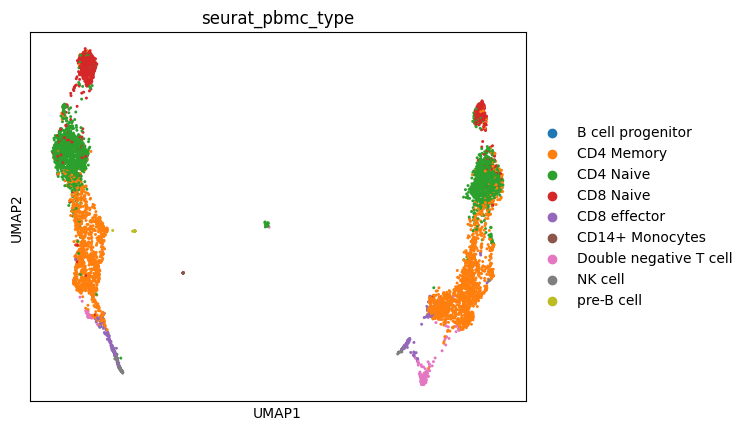

In [33]:
sc.pl.umap(
    adata,
    color = 'seurat_pbmc_type',
    save = '_cell_type.png'
)
out_files.append('output/umap_cell_type.png')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


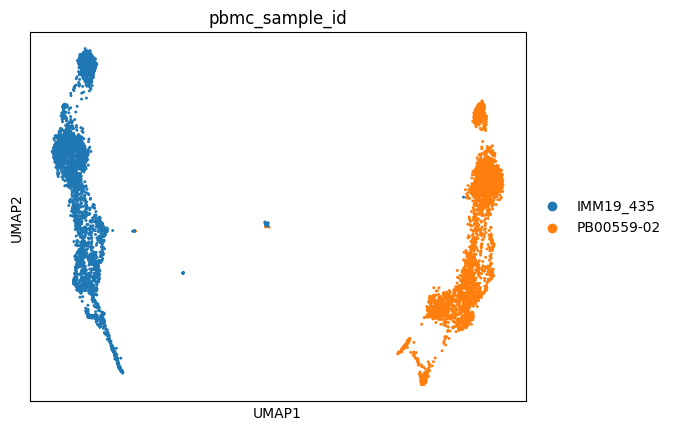

In [34]:
sc.pl.umap(
    adata,
    color = 'pbmc_sample_id',
    save = '_all_samples.png'
)
out_files.append('output/umap_all_samples.png')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


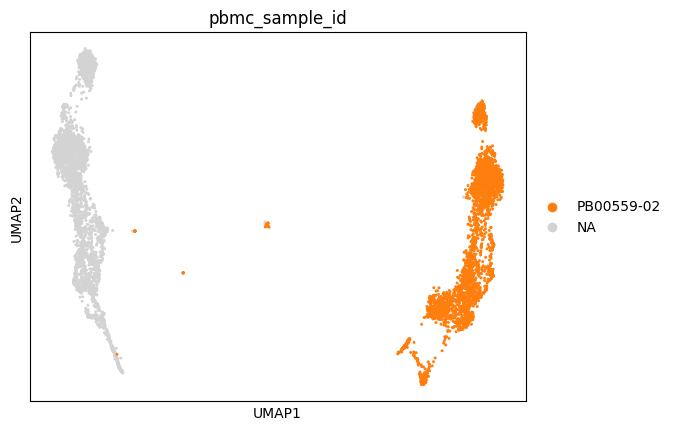

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


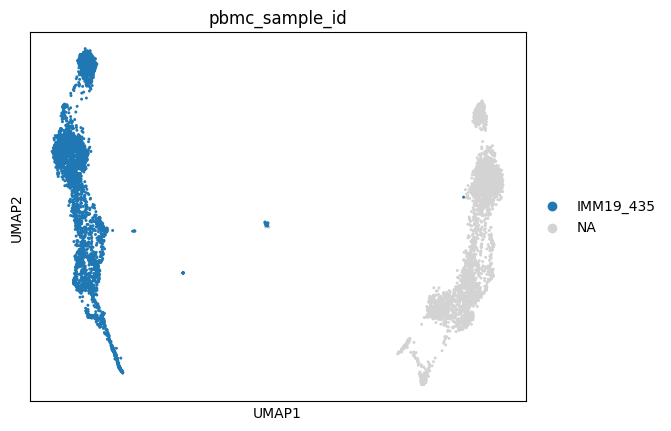

In [35]:
samples = adata.obs['pbmc_sample_id'].unique()
for sample in samples:
    sc.pl.umap(
        adata,
        color = 'pbmc_sample_id',
        groups = sample,
        save = '_{s}.png'.format(s = sample)
    )
    out_files.append('output/umap_{s}.png'.format(s = sample))

## Are there differences in expression in CD4 Memory T cells?

In [36]:
cd4_adata = adata[adata.obs['seurat_pbmc_type'] == 'CD4 Memory'].copy()

In [37]:
sc.tl.rank_genes_groups(
    cd4_adata,
    groupby = 'pbmc_sample_id',
    method = 'wilcoxon'
)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


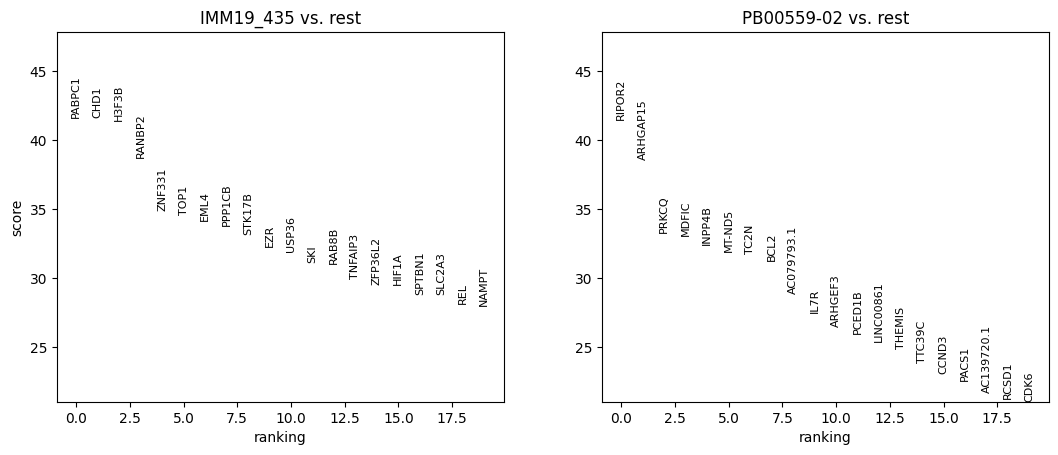

In [38]:
sc.pl.rank_genes_groups(cd4_adata)

In [39]:
cd4_adata.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [40]:
cd4_deg_df = pd.DataFrame({
    'gene': extract_result(cd4_adata, 'names'),
    'score': extract_result(cd4_adata, 'scores'),
    'pval': extract_result(cd4_adata, 'pvals'),
    'padj': extract_result(cd4_adata, 'pvals_adj'),
    'logfc': extract_result(cd4_adata, 'logfoldchanges')
})

In [41]:
cd4_deg_df.head(10)

,gene,score,pval,padj,logfc
0,PABPC1,41.647247,0.000000e+00,0.000000e+00,NaN
1,CHD1,41.600758,0.000000e+00,0.000000e+00,NaN
2,H3F3B,41.382801,0.000000e+00,0.000000e+00,NaN
3,RANBP2,38.727051,0.000000e+00,0.000000e+00,NaN
4,ZNF331,34.838348,6.391972e-266,4.683489e-263,NaN
5,TOP1,34.574841,6.036205e-262,3.869962e-259,NaN
6,EML4,34.120041,3.721290e-255,2.120722e-252,NaN
7,PPP1CB,33.753605,9.465384e-250,4.854795e-247,NaN
8,STK17B,33.141991,7.386787e-241,3.157236e-238,NaN
9,EZR,32.246960,3.880491e-228,1.326869e-225,NaN


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


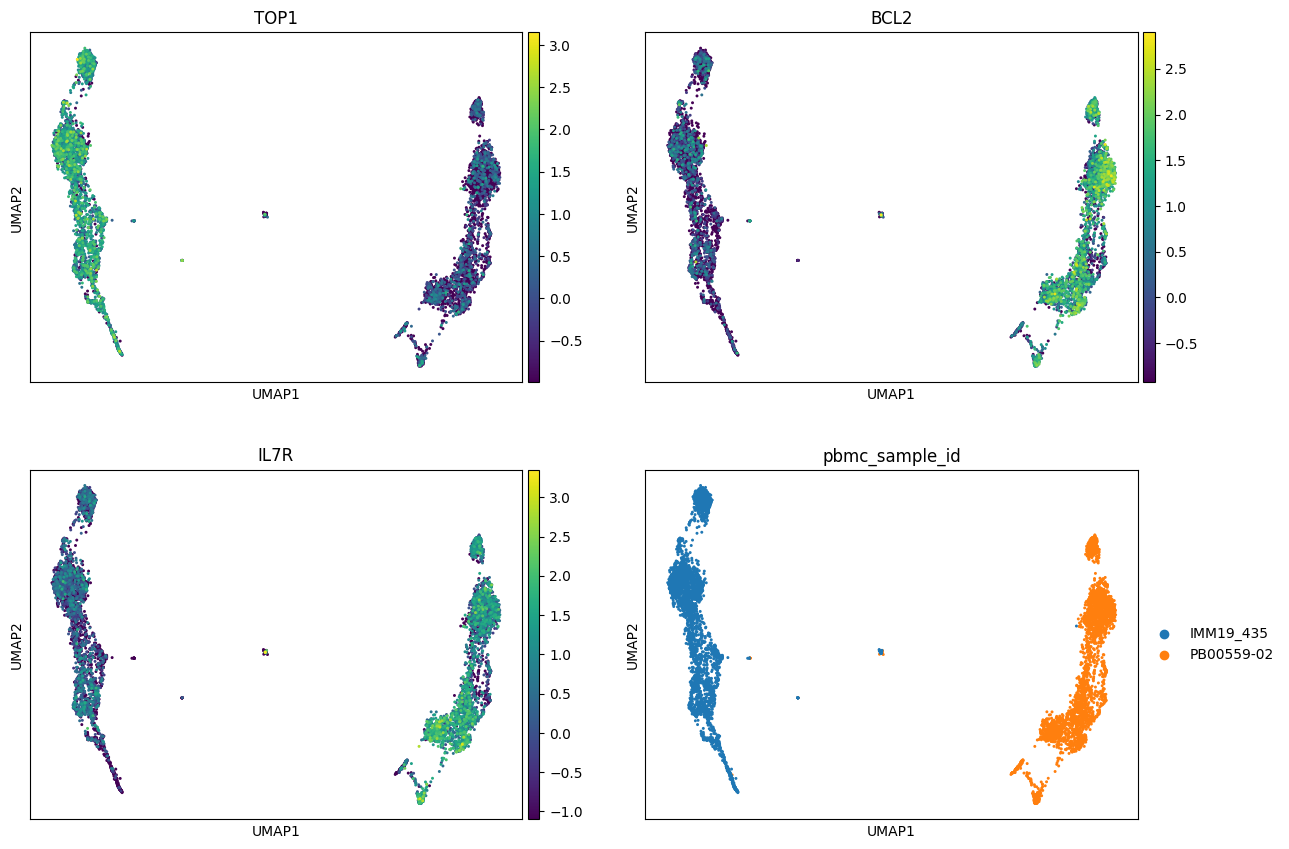

In [51]:
sc.pl.umap(
    adata,
    color = ['TOP1','BCL2','IL7R','pbmc_sample_id'],
    ncols = 2
)

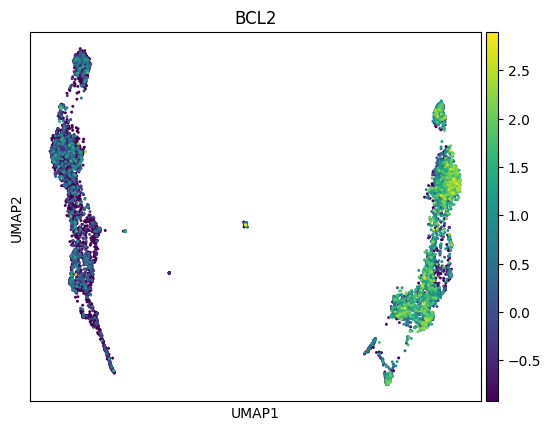

In [43]:
sc.pl.umap(
    adata,
    color = 'BCL2'
)

In [44]:
cd4_deg_df.to_csv('output/leukopak_vs_PBMC_cd4_memory_deg.csv')
out_files.append('output/leukopak_vs_PBMC_cd4_memory_deg.csv')

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


Yes, there are differences. We should be mindful of these in our analysis if we want to compare between our leukopak control and our Ficoll PBMC samples.

## Save files for later use in HISE

In [45]:
study_space_uuid = '00a53fa5-18da-4333-84cb-3cc0b0761201'
title = 'CertPro Leukopak Control Comparison {d}'.format(d = date.today())

In [46]:
search_id = 'explicable_lacewing'

In [47]:
in_files = desc['file.id'].tolist()
in_files

['d929e7ef-162b-410b-b765-ae1d7d73bae8',
 '20fa8373-4779-4fbe-8ce7-4efc677606fc']

In [48]:
out_files

['output/cell_meta_and_umap_coords.csv',
 'output/umap_cell_type.png',
 'output/umap_all_samples.png',
 'output/umap_PB00559-02.png',
 'output/umap_IMM19_435.png',
 'output/leukopak_vs_PBMC_cd4_memory_deg.csv']

In [49]:
hisepy.upload.upload_files(
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    files = out_files,
    destination = search_id
)

you are trying to upload file_ids... ['output/cell_meta_and_umap_coords.csv', 'output/umap_cell_type.png', 'output/umap_all_samples.png', 'output/umap_PB00559-02.png', 'output/umap_IMM19_435.png', 'output/leukopak_vs_PBMC_cd4_memory_deg.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'c8e95923-bf97-4f2e-8ac9-d1ec9c367afb',
 'files': ['output/cell_meta_and_umap_coords.csv',
  'output/umap_cell_type.png',
  'output/umap_all_samples.png',
  'output/umap_PB00559-02.png',
  'output/umap_IMM19_435.png',
  'output/leukopak_vs_PBMC_cd4_memory_deg.csv']}

## Session Info/Package Versions

In [50]:
import session_info
session_info.show()